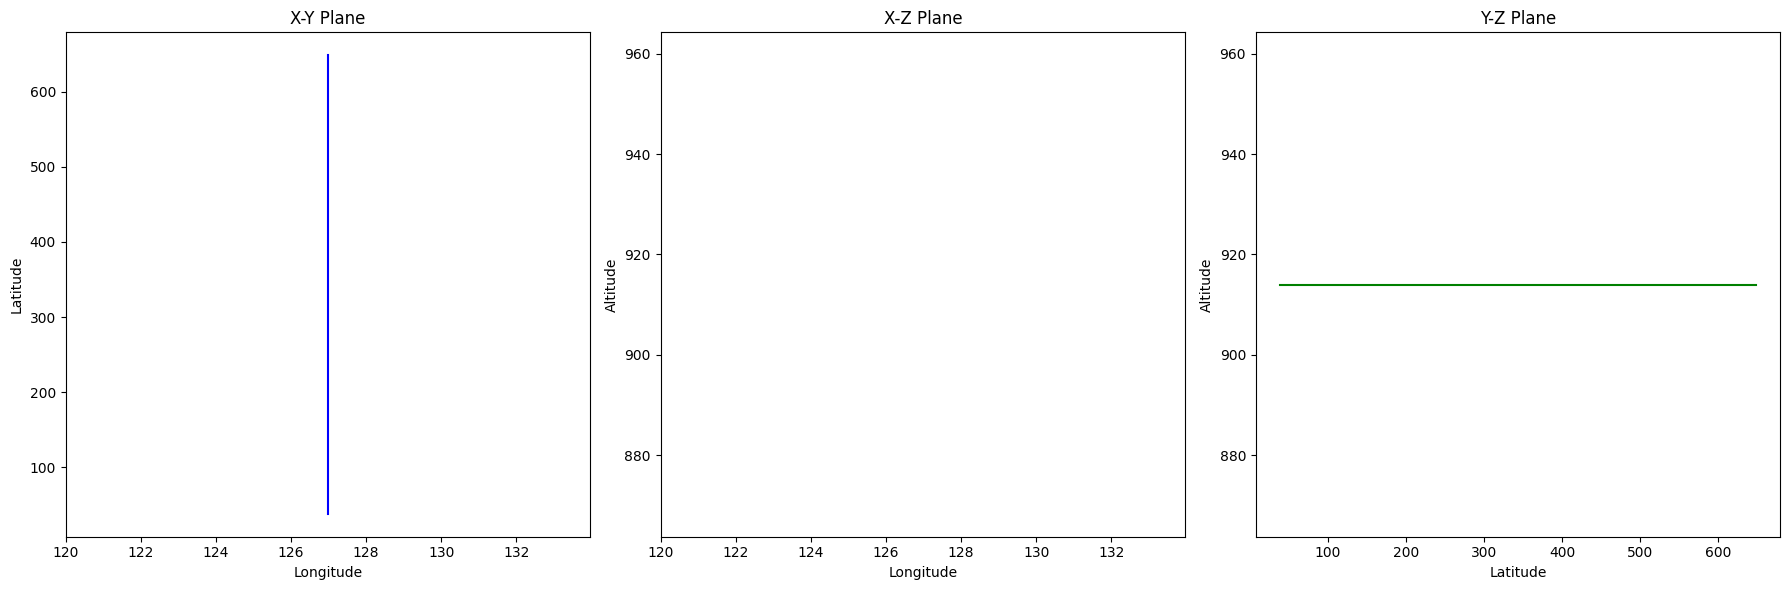

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 계산을 위한 회전 행렬을 생성하는 함수
def euler_to_rotation_matrix(roll, pitch, yaw):
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(roll), -np.sin(roll)],
                    [0, np.sin(roll), np.cos(roll)]])

    R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                    [0, 1, 0],
                    [-np.sin(pitch), 0, np.cos(pitch)]])

    R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                    [np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]])

    R = np.dot(R_z, np.dot(R_y, R_x))
    return R

# 자세 각도를 업데이트하는 함수
def update_attitude(euler_angles, gyro_rates, dt):
    roll, pitch, yaw = euler_angles
    p, q, r = np.radians(gyro_rates)  # 도를 라디안으로 변환
    roll += p * dt
    pitch += q * dt
    yaw += r * dt
    return roll, pitch, yaw

# 속도 및 위치를 업데이트하는 함수
def update_position_velocity(position, velocity, accel_body, euler_angles, dt):
    R = euler_to_rotation_matrix(*np.radians(euler_angles))
    accel_ned = np.dot(R, accel_body)  # Body to NED
    velocity += accel_ned * dt
    position += velocity * dt
    return position, velocity

# 값을 저장할 임의의 배열 생성
results_list = []

# 초기 조건 설정
# 위,경,고도는 서울 상공 기준 설정
# 기체를 세스나 172로 설정하며 일반적인 세스나 항공기의 운항 고도로 설정
# 롤, 피치, 요 각각 0으로 설정하며 항공기가 Level Flight 중이라 가정
# NED 속도는 N만 주어지며 등속 수평 비행 가정, 따라서 P,Q,R 및 axb, ayb, azb 또한 0
lat = 37.5665  # 위도
lon = 126.9780  # 경도
alt = 914  # 고도 (미터)
roll = 0  # 롤
pitch = 0  # 피치
yaw = 0  # 요 (북쪽을 향함)

vn = 61.1  # N 방향 속도 (m/s)
ve = 0     # E 방향 속도 (m/s)
vd = 0     # D 방향 속도 (m/s)
p = 0  # 각속도 P
q = 0  # 각속도 Q
r = 0  # 각속도 R
axb = 0  # Body 가속도 X
ayb = 0  # Body 가속도 Y
azb = 0  # Body 가속도 Z

# 시뮬레이션 매개변수
dt = 0.01  # Time Stab
steps = 1000  # 시뮬레이션 스텝 수

# 시뮬레이션을 위한 데이터 초기화
positions = np.zeros((steps, 3))
velocities = np.zeros((steps, 3))
euler_angles = np.array([roll, pitch, yaw])

# 시뮬레이션 실행
position = np.array([lon, lat, alt])
velocity = np.array([ve, vn, vd])

#dt 간격, 총 1000번 스탭동안의 반복을 통해 시뮬레이션 실행
for i in range(steps):
    euler_angles = update_attitude(euler_angles, [p, q, r], dt)
    position, velocity = update_position_velocity(position, velocity, [axb, ayb, azb], euler_angles, dt)
    positions[i] = position
    result = {
        'Step': i + 1,
        'Longitude': position[0],
        'Latitude': position[1],
        'Altitude': position[2],
        'Roll': np.degrees(euler_angles[0]),
        'Pitch': np.degrees(euler_angles[1]),
        'Yaw': np.degrees(euler_angles[2]),
        'Velocity E': velocity[0],
        'Velocity N': velocity[1],
        'Velocity D': velocity[2]
    }
    results_list.append(result)

# 모든 스텝 실행 후 결과 저장을 위한 Pandas DataFrame 생성
results = pd.DataFrame(results_list)

# 데이터 프레임을 CSV로 저장
results.to_csv('simulation_results.csv', index=False)

# 그래프로 Plot
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# x-y 평면
ax[0].plot(positions[:, 0], positions[:, 1], 'b-')
ax[0].set_title("X-Y Plane")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")

# x-z 평면
ax[1].plot(positions[:, 0], positions[:, 2], 'r-')
ax[1].set_title("X-Z Plane")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Altitude")

# y-z 평면
ax[2].plot(positions[:, 1], positions[:, 2], 'g-')
ax[2].set_title("Y-Z Plane")
ax[2].set_xlabel("Latitude")
ax[2].set_ylabel("Altitude")

plt.tight_layout()
plt.show()